# IMPORT LIBRARIES

In [107]:
import os
import numpy as np
import pandas as pd

import csv
import re
import string
import pickle

import seaborn as sns

import nltk
from nltk import word_tokenize

from tqdm import tqdm
from typing_extensions import Counter

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%config Completer.use_jedi = False

In [3]:
pd.set_option("max_colwidth", 200)

# EXTRACT and LOAD DATA

The dataset is a file named SMSSpamCollection with 2 features - the target label which is ***ham/spam*** and the corresponding ***text*** message. The following lines of code extracts the data and loads into a pandas dataframe.

In [4]:
os.chdir("..")

In [5]:
dataset_path = os.path.join(os.getcwd(), 
                            'Dataset\\SMSSpamCollection')

column_names = [
    'Label', 
    'Text'
    ]
sms_df = pd.read_csv(dataset_path, 
                     sep="\t", 
                     header=None, 
                     encoding="utf-8", 
                     quoting=csv.QUOTE_NONE, 
                     names=column_names)

# EXPLORE DATA

Exploring the dataset is important to understand the features present in the data and how they impact the target label. The *info()* gives the information regarding the columns present and the no. of entries in the dataset. 

In [6]:
sms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5574 non-null   object
 1   Text    5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
ham_count, spam_count = list(sms_df['Label'].value_counts())

### Count of SPAM and HAM text messages 

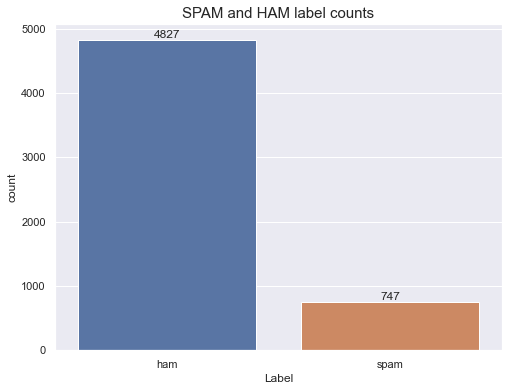

In [8]:
sns.set(rc = {'figure.figsize':(8,6)})
ax = sns.countplot(x='Label', 
                  data=sms_df)
ax.set_title('SPAM and HAM label counts', 
             fontsize=15)
for label in ax.containers:
    ax.bar_label(label)

The count of SPAM and HAM text messages are uneven. Due to imbalanced data, the training of the model becomes difficult as it might tend to bias.

### Character length of text messages 

In [9]:
sms_df[sms_df['Label'] == 'spam']['Text'][:5]

2       Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
5               FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
8     WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9        Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
11                         SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info
Name: Text, dtype: object

In [10]:
sms_df[sms_df['Label'] == 'ham']['Text'][:5]

0    Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1                                                                                      Ok lar... Joking wif u oni...
3                                                                  U dun say so early hor... U c already then say...
4                                                      Nah I don't think he goes to usf, he lives around here though
6                                      Even my brother is not like to speak with me. They treat me like aids patent.
Name: Text, dtype: object

In [11]:
sms_df['Char_Length'] = sms_df['Text'].apply(len)
avg_len_df = sms_df.groupby('Label', 
                            as_index=False)['Char_Length'].mean()
avg_len_df

,Label,Char_Length
0,ham,71.471929
1,spam,138.676037


Text(0.5, 1.0, 'Distribution of character length w.r.t label')

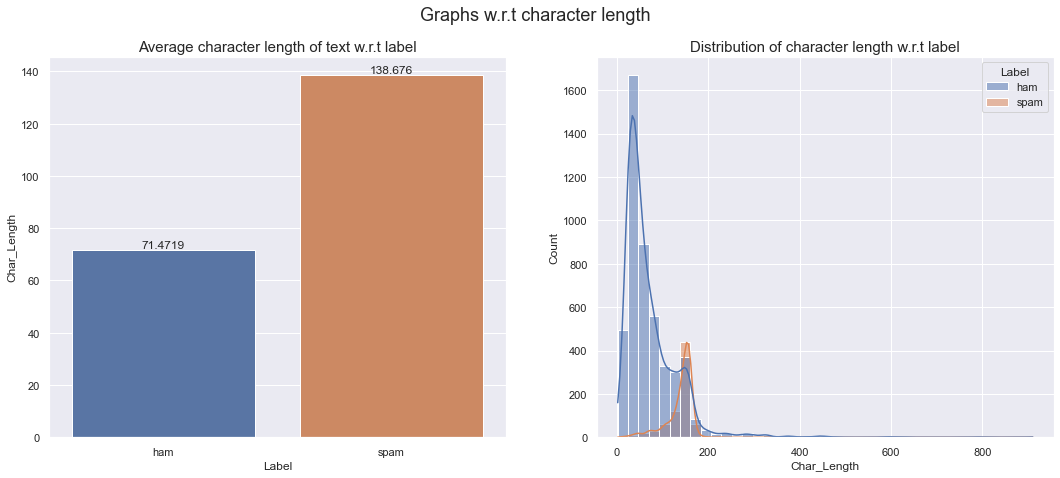

In [12]:
figure, ax = plt.subplots(1, 2,
                         figsize=(18,7))

figure.suptitle('Graphs w.r.t character length', fontsize=18)

plt.subplot(1, 2, 1)
ax[0] = sns.barplot(x='Label', 
                    y='Char_Length',
                    data=avg_len_df)
ax[0].set_title('Average character length of text w.r.t label', 
                fontsize=15)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.histplot(x='Char_Length',
                     hue='Label',
                     stat='count',
                     data=sms_df,
                     bins=40,
                     kde=True)
ax[1].set_title('Distribution of character length w.r.t label', 
                fontsize=15)

Average character length of HAM text messages is less than the other. The average text length of *HAM* and *SPAM* text messages is approximately 71 and 138 respectively.

### Word length of text messages 

In [13]:
sms_df['Word_Length'] = sms_df['Text'].apply(lambda x: len(nltk.word_tokenize(x)))
avg_wordlen_df = sms_df.groupby('Label', 
                                as_index=False)['Word_Length'].mean()
avg_wordlen_df

,Label,Word_Length
0,ham,17.434846
1,spam,27.998661


Text(0.5, 1.0, 'Distribution of word length w.r.t label')

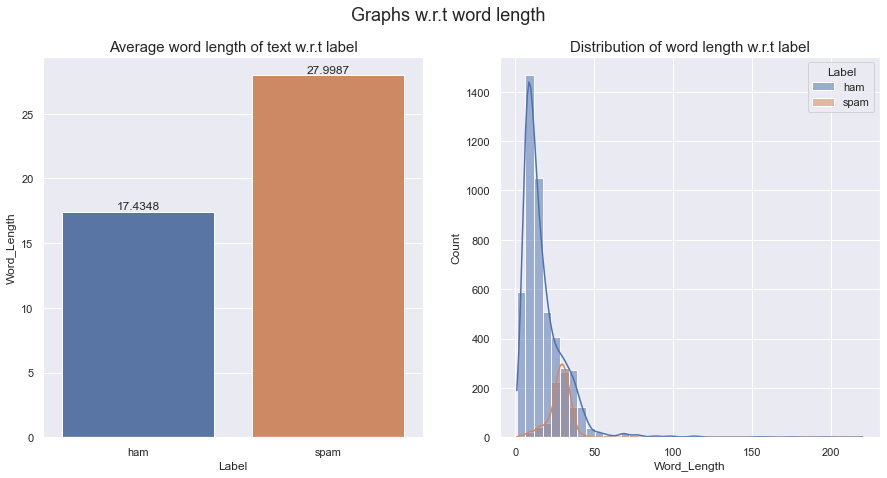

In [14]:
figure, ax = plt.subplots(1, 2,
                         figsize=(15,7))

figure.suptitle('Graphs w.r.t word length', 
                fontsize=18)

plt.subplot(1, 2, 1)
ax[0] = sns.barplot(x='Label', 
                    y='Word_Length',
                    data=avg_wordlen_df)
ax[0].set_title('Average word length of text w.r.t label', 
                fontsize=15)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.histplot(x='Word_Length',
                     hue='Label',
                     stat='count',
                     data=sms_df,
                     bins=40,
                     kde=True)
ax[1].set_title('Distribution of word length w.r.t label', 
                fontsize=15)

Average word length of HAM text messages is less than the other. The average word length of HAM and SPAM text messages is approximately 17 and 28 respectively.

### Frequency of words 

In [88]:
ham_count = Counter(" ".join(sms_df[sms_df['Label'] == 'ham']['Text']).split()).most_common(30)
top_ham_df = pd.DataFrame.from_dict(ham_count)
top_ham_df = top_ham_df.rename(columns={0: 'Word', 1: 'Frequency'})
spam_count = Counter(" ".join(sms_df[sms_df['Label'] == 'spam']['Text']).split()).most_common(30)
top_spam_df = pd.DataFrame.from_dict(spam_count)
top_spam_df = top_spam_df.rename(columns={0: 'Word', 1: 'Frequency'})

Text(0.5, 1.0, 'Top 30 spam words')

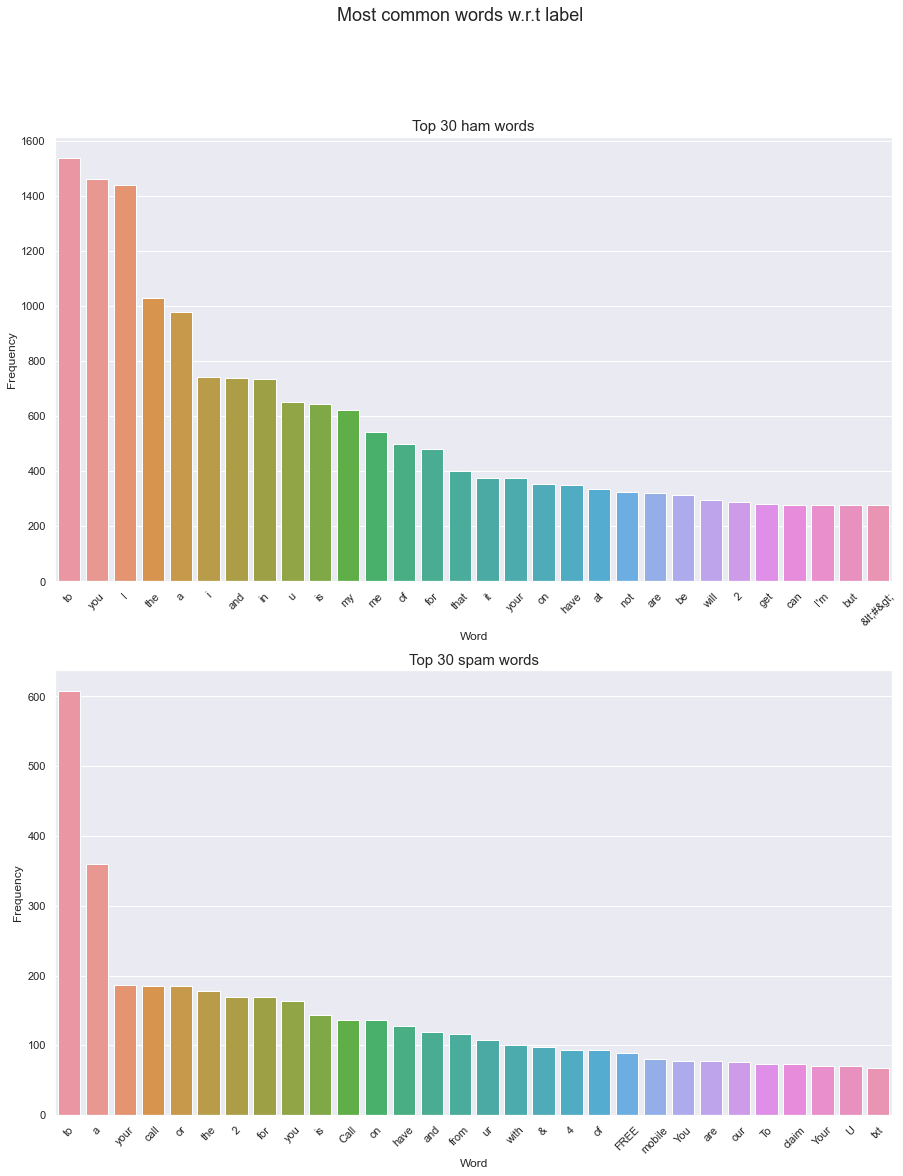

In [96]:
figure, ax = plt.subplots(2, 1,
                         figsize=(15,18))

figure.suptitle('Most common words w.r.t label', 
                fontsize=18)

plt.subplot(2, 1, 1)
plt.xticks(rotation=45)
ax[0] = sns.barplot(x='Word', 
                    y='Frequency',
                    data=top_ham_df)
ax[0].set_title('Top 30 ham words', 
                fontsize=15)

plt.subplot(2, 1, 2)
plt.xticks(rotation=45)
ax[1] = sns.barplot(x='Word', 
                    y='Frequency',
                    data=top_spam_df)
ax[1].set_title('Top 30 spam words', 
                fontsize=15)

# PRE-PROCESS DATA

### Features and Target  

In [97]:
label_df = sms_df.Label

sms_df.drop('Label', axis=1, inplace=True)

In [98]:
contractions_dict = {     
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "iit will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

In [99]:
# Formatting text
def format_text(text):
    
    # Remove hyperlinks
    url = '((http|https)://)[a-zA-Z0-9.]+(com)?[a-zA-Z0-9./]*|((http|https)//)[a-zA-Z0-9.]+' \
          '(com)?[a-zA-Z0-9./]*|((http|https)://www.)[a-zA-Z0-9.]+(com)?[a-zA-Z0-9./]*|((http|https)//www.)' \
          '[a-zA-Z0-9.]+(com)[a-zA-Z0-9./]*?|(www.)[a-zA-Z0-9.]+(com)?[a-zA-Z0-9./]*'
    text = re.sub(url,
                  "", 
                  text)
    
    # Remove alphanumeric
    alphnum = '\w*\d\w*'
    text = re.sub(alphnum,
                  "", 
                  text)
    
    ## Remove html tags
    html = re.compile(r'<.*?>')
    text = html.sub(r'', 
                    text)
    
    # Remove contractions
    def expand_contractions(text, 
                            contractions_dict):
        
        contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())), 
                                          flags=re.IGNORECASE | re.DOTALL)

        def expand_match(contraction):
            
            match = contraction.group(0)
            first_char = match[0]
            
            expanded_contraction = contractions_dict.get(match) \
                if contractions_dict.get(match) \
                else contractions_dict.get(match.lower())
            expanded_contraction = expanded_contraction
            
            return expanded_contraction

        expanded_text = contractions_pattern.sub(expand_match, 
                                                 text)
        expanded_text = re.sub("'", 
                               "", 
                               expanded_text)
        
        return expanded_text

    text = expand_contractions(text, 
                               contractions_dict)
    
    # Remove junk character
    text = text.encode("ascii", 
                       "ignore").decode("utf-8", 
                                        "ignore")    

    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    
    # Remove white spaces
    text = " ".join(text.split())
    
    # Tokenize tweets
    text = word_tokenize(text.lower())
    
    # Remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopwords]
    
    # Apply lemmatization
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    
    return text


### TF-IDF 

In [102]:
tfidf = TfidfVectorizer(analyzer=format_text)
tfidf_data = tfidf.fit_transform(sms_df['Text'])

### Save the TFIDF model 

In [106]:
pickle.dump(tfidf_data, open('Models/tfidf_model.pkl', 'wb'))
proc_df = pd.DataFrame(tfidf_data.toarray())
proc_df.columns = tfidf.get_feature_names()
print(proc_df.shape)
proc_df

(5574, 7638)


C:\ProgramData\Anaconda3\envs\PRJ4yr\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aah,aaniye,aaooooright,aathilove,aathiwhere,ab,abbey,abdomen,abeg,...,zebra,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Merge the word and character columns from the dataset 

In [114]:
# Normalise the 2 columns
min_max_sc = MinMaxScaler()

new_df = sms_df.filter(['Char_Length', 'Word_Length'], axis=1)